In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Wed Jun 21 22:36:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   29C    P8    54W / 230W |   1480MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [4]:
n_mels = 8
n_outputs = 61
n_frames = 400
sr = 24000
fps = 30
train_csv_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone_raw_30fps.csv',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone_raw_30fps.csv',
                  ]
train_wav_files = ['/Storage/speech/face/rvh_viseme2_1_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_2_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_3_iPhone.wav',
                   '/Storage/speech/face/rvh_viseme2_4_iPhone.wav',
                  ]

test_csv_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone_30fps.csv']
test_wav_files = ['/Storage/speech/face/MySlate_6_박수철의_iPhone.wav']

### Model

In [5]:
from model.model_flow5 import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, out_dim=n_outputs)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
print('done')

done


### Load

In [6]:
save_dir = '/data/scpark/save/lips/train06.21-5/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 13000, model, None, optimizer)

total 0


In [7]:
import torch
from data.dataset import LipsDataset, Collate

train_dataset = LipsDataset(train_wav_files, train_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=True)
print('train dataset :', len(train_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, num_workers=1, shuffle=True, batch_size=8, 
                                           collate_fn=Collate(n_frames, n_mels))
print(train_loader)

test_dataset = LipsDataset(test_wav_files, test_csv_files, n_frames, n_mels=n_mels, sr=sr, fps=fps, perturb=False)
print('test dataset :', len(test_dataset))
test_loader = torch.utils.data.DataLoader(test_dataset, num_workers=1, shuffle=True, batch_size=8,
                                           collate_fn=Collate(n_frames, n_mels))
print(test_loader)

train dataset : 28308
test dataset : 1413


test : 0 18.12139892578125
test : 1 17.554126739501953
test : 2 16.82351303100586
test : 3 17.033296585083008
test : 4 17.315364837646484
test : 5 18.026321411132812
test : 6 17.702348709106445
test : 7 17.690685272216797
test : 8 17.682409286499023
test : 9 18.974960327148438
test_loss : 17.69244384765625


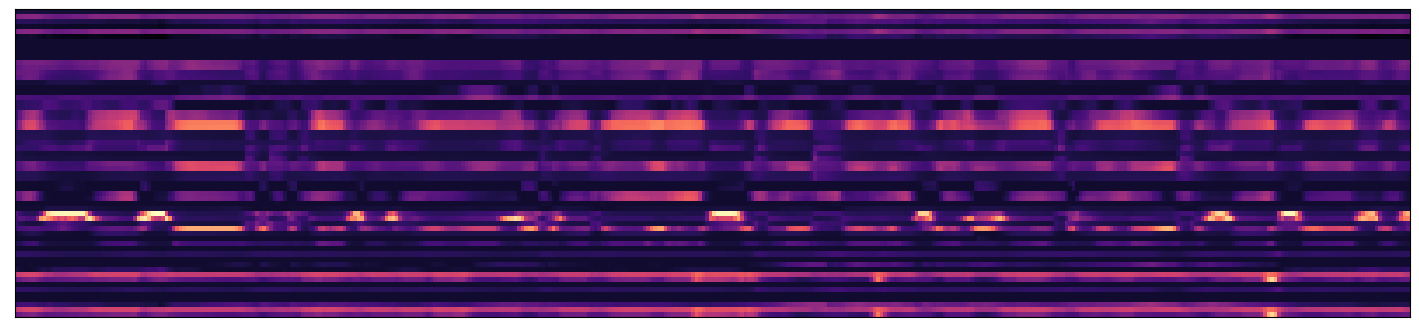

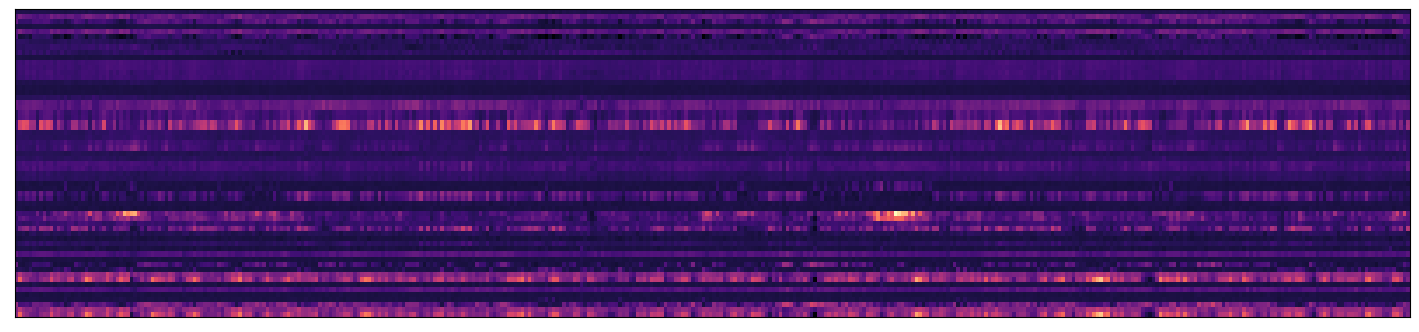

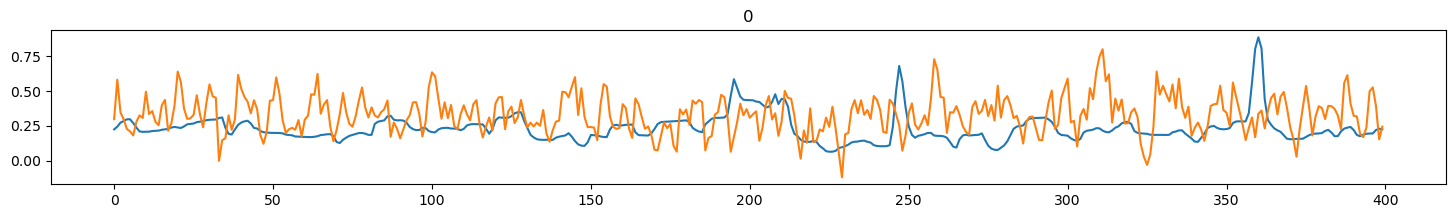

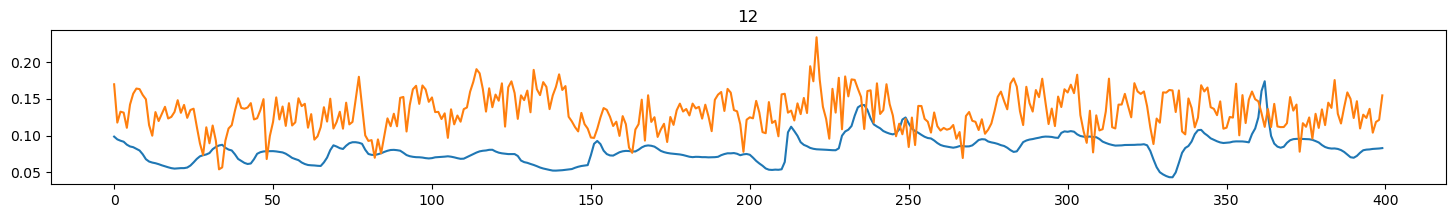

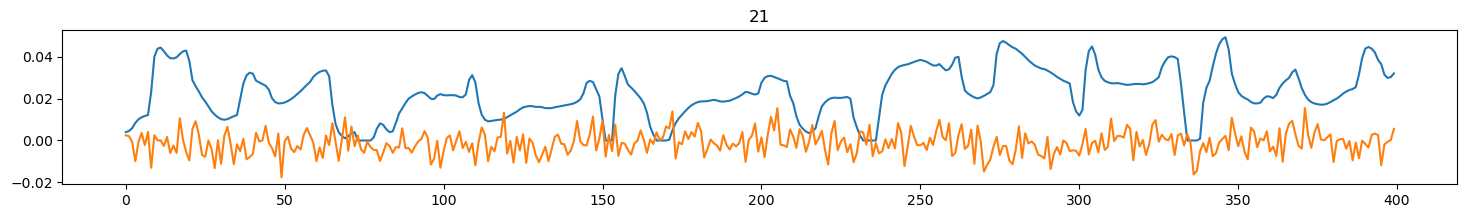

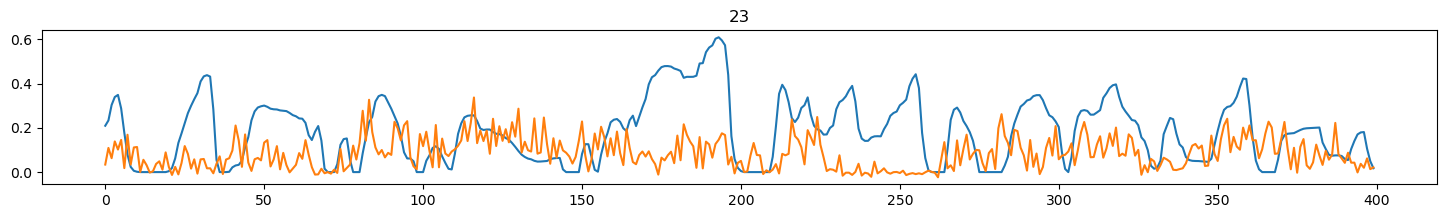

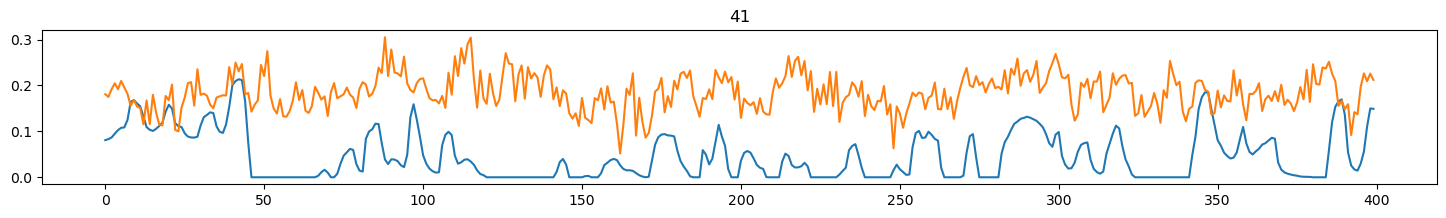

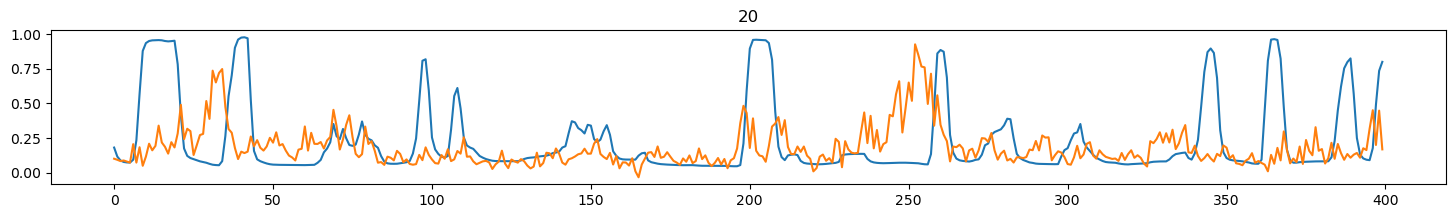

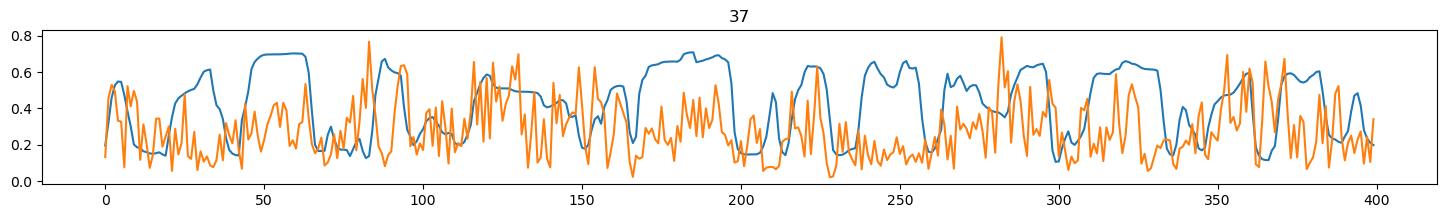

26101
26101 -3.8786113262176514
26102
26102 -3.869424343109131
26103
26103 -3.9113006591796875
26104
26104 -3.737029552459717
26105
26105 -3.769822597503662
26106
26106 -3.591310739517212
26107
26107 -3.664067029953003
26108
26108 -3.592158794403076
26109
26109 -3.639852285385132
26110
26110 -3.4547924995422363
26111
26111 -3.6949477195739746
26112
26112 -3.5859086513519287
26113
26113 -3.7664895057678223


In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        inputs = batch['inputs'].transpose(1, 2).to(device)
        targets = batch['outputs'].transpose(1, 2).to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets)
        
        print(step)
        loss = outputs['total_loss']
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 100 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 100 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                inputs = batch['inputs'].transpose(1, 2).to(device)
                targets = batch['outputs'].transpose(1, 2).to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets)
                    
                loss = outputs['total_loss']
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            with torch.no_grad():
                pred = model.inference(inputs)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [0, 12, 21, 23, 41]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(pred[0].data.cpu().numpy()[i])
                plt.show()
                
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 1000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [9]:
save(save_dir, step, model, None, optimizer)

saved /data/scpark/save/lips/train06.21-5/save_25933
